In [1]:
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import numpy as np

import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
"""
#connect with drive
from google.colab import drive
drive.mount('/content/drive')
"""

"\n#connect with drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
"""
# Path to data:
# David's path
path = '/content/drive/MyDrive/Dengue_GIS_Visualization/DengueData/'
# Dana's path
#path='/content/drive/MyDrive/Dengue_GIS Visualization/Dengue_GIS_Visualization/DengueData/'
"""

"\n# Path to data:\n# David's path\npath = '/content/drive/MyDrive/Dengue_GIS_Visualization/DengueData/'\n# Dana's path\n#path='/content/drive/MyDrive/Dengue_GIS Visualization/Dengue_GIS_Visualization/DengueData/'\n"

In [4]:
# Read Data
merge_cases_temp_precip = pd.read_csv('Data/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv')
# Remove extra column
merge_cases_temp_precip = merge_cases_temp_precip.drop('Unnamed: 0', 1)
merge_cases_temp_precip.LastDayWeek = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
merge_cases_temp_precip

/var/folders/4w/k6c16td51cv9ytcmnnvx3mpw0000gn/T/ipykernel_27690/324749813.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  merge_cases_temp_precip = merge_cases_temp_precip.drop('Unnamed: 0', 1)


,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek,MONTH,temperature_medellin,percipitation_medellin,percipitation_medellin_rural,percipitation_medellin_urbano
0,1,"['2007', 'w01']",2007,200701,2007-01-06,1,21.009283,13.096688,14.097693,12.628933
1,0,"['2007', 'w02']",2007,200702,2007-01-13,1,21.009283,8.437044,6.910390,9.067214
2,0,"['2007', 'w03']",2007,200703,2007-01-20,1,21.009283,19.373165,21.616968,18.406665
3,0,"['2007', 'w04']",2007,200704,2007-01-27,1,21.009283,0.000000,0.000000,0.000000
4,0,"['2007', 'w05']",2007,200705,2007-02-03,2,20.982925,3.725206,3.144225,3.901021
...,...,...,...,...,...,...,...,...,...,...
619,28,"['2018', 'w48']",2018,201848,2018-12-01,12,20.936353,8.916642,8.656351,9.114419
620,12,"['2018', 'w49']",2018,201849,2018-12-08,12,20.936353,17.006086,16.076869,17.334870
621,27,"['2018', 'w50']",2018,201850,2018-12-15,12,20.936353,5.673248,5.388778,5.794555
622,17,"['2018', 'w51']",2018,201851,2018-12-22,12,20.936353,2.785103,2.708024,2.810241


# Time Series

## Data visualization

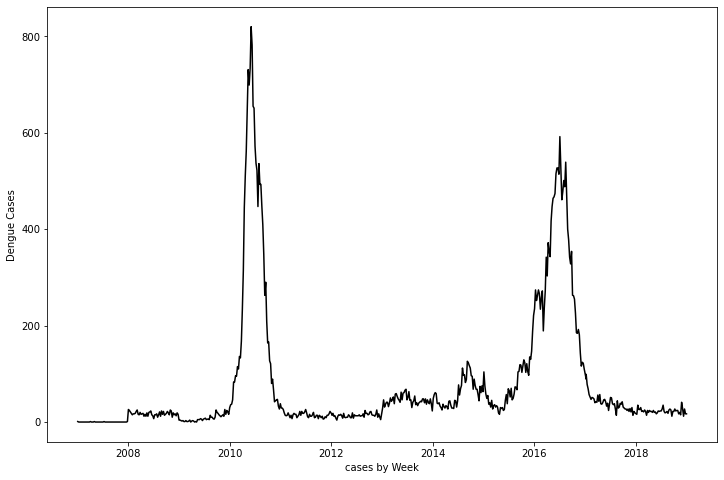

In [5]:
# Dengue cases in time
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (12, 8))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label) 
    plt.ylabel('Dengue Cases')

timeseries(merge_cases_temp_precip['LastDayWeek'], merge_cases_temp_precip['cases_medellin'], 'cases by Week')

## DataSet

In [6]:
dataset = merge_cases_temp_precip[['temperature_medellin','percipitation_medellin','cases_medellin']]
dataset.index = merge_cases_temp_precip.LastDayWeek
dataset  #DF

,temperature_medellin,percipitation_medellin,cases_medellin
LastDayWeek,,,
2007-01-06,21.009283,13.096688,1
2007-01-13,21.009283,8.437044,0
2007-01-20,21.009283,19.373165,0
2007-01-27,21.009283,0.000000,0
2007-02-03,20.982925,3.725206,0
...,...,...,...
2018-12-01,20.936353,8.916642,28
2018-12-08,20.936353,17.006086,12
2018-12-15,20.936353,5.673248,27


# Prepare data to supervised learning time series

we will use:
* data: is the dataframe in our case (Dengue Cases, Precipitation and Temperature)
* n_in: is the number of lag weeks in the past (length of window)

The heart of this "series_to_supervised" function is the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html">shift</a> fuction of pandas

This function gets as input the number of periods(in this case the number of weeks represented as rows up or down in the dataframe) to move the columns of a dataframe.
E.g. 
* If we have merge_cases_temp_precip['cases_medellin'].shift(1) all the rows of column cases_medellin will move one row down
* If we have merge_cases_temp_precip['cases_medellin'].shift(-1) all the rows of column cases_medellin will move one row up


In [7]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

### normalize features
As we are working with a Neural Network the data values ​​must be normalized to help backpropagation algorithm
So we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a> from sklearn

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaler between 0 and 1
scaled = scaler.fit_transform(dataset) # As we can see data set has 3 Columns (This shape is also important for inverse scaler as we will see in future)

In [9]:
# length of window
weeks = 10

# frame as supervised learning
data = series_to_supervised(scaled, n_in=weeks)
DataFrame(data).head()

,var1(t-10),var2(t-10),var3(t-10),var1(t-9),var2(t-9),var3(t-9),var1(t-8),var2(t-8),var3(t-8),var1(t-7),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
10,0.364241,0.103033,0.00122,0.364241,0.066375,0.0,0.364241,0.152411,0.0,0.364241,...,0.0,0.493659,0.251632,0.0,0.493659,0.194133,0.00000,0.493659,0.339599,0.00000
11,0.364241,0.066375,0.00000,0.364241,0.152411,0.0,0.364241,0.000000,0.0,0.356053,...,0.0,0.493659,0.194133,0.0,0.493659,0.339599,0.00000,0.493659,0.287922,0.00000
12,0.364241,0.152411,0.00000,0.364241,0.000000,0.0,0.356053,0.029307,0.0,0.356053,...,0.0,0.493659,0.339599,0.0,0.493659,0.287922,0.00000,0.493659,0.718713,0.00000
13,0.364241,0.000000,0.00000,0.356053,0.029307,0.0,0.356053,0.095100,0.0,0.356053,...,0.0,0.493659,0.287922,0.0,0.493659,0.718713,0.00000,0.434987,0.456353,0.00122
14,0.356053,0.029307,0.00000,0.356053,0.095100,0.0,0.356053,0.011560,0.0,0.356053,...,0.0,0.493659,0.718713,0.0,0.434987,0.456353,0.00122,0.434987,0.371302,0.00000


## Features Set

In [10]:
# We define the number of features as 3 (Temperature, Precipitation and Dengue Cases)
n_features = 3
# The features to train the model will be all except the values of the actual week 
# We can't use the temperature and precipitation in week t because whe need to resample a a 3D Array
features_set = DataFrame(data.values[:,:-n_features])
# Convert pandas data frame to np.array to reshape as 3D Array
features_set = features_set.to_numpy()
features_set

array([[0.36424094, 0.10303316, 0.00121951, ..., 0.49365894, 0.19413316,
        0.        ],
       [0.36424094, 0.0663752 , 0.        , ..., 0.49365894, 0.33959896,
        0.        ],
       [0.36424094, 0.15241093, 0.        , ..., 0.49365894, 0.28792167,
        0.        ],
       ...,
       [0.28320738, 0.60463713, 0.03292683, ..., 0.34158643, 0.13378884,
        0.01463415],
       [0.28320738, 0.20007748, 0.02804878, ..., 0.34158643, 0.0446321 ,
        0.03292683],
       [0.28320738, 0.3982439 , 0.02926829, ..., 0.34158643, 0.02191073,
        0.02073171]])

## Labels Set

In [11]:
# We will use Dengue cases in last week 
labels_set = DataFrame(data.values[:,-1])
# Convert pandas data frame to np.array
labels_set = labels_set.to_numpy()
labels_set

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.03170732],
       [0.02926829],
       [0.02560976],
       [0.02195122],
       [0.01829268],
       [0.020

## Train Test Split

In [12]:
# We need a sequence so we can't split randomly
# To divide into Train (90%) and test (10%) to do that we need to know the 90% of the total dataframe
size = features_set.shape[0]
split = int(size*(9/10))

### train

In [13]:
# We will train with 1st 90% of data and test with last 10%
train_X = features_set[:split] ##90% train
train_y = labels_set[:split]  ##90% train

### test

In [14]:
test_X = features_set[split:] ##10% test
test_y = labels_set[split:] ##10% test

## Reshape

In [15]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(552, 10, 3) (552, 1) (62, 10, 3) (62, 1)


## Model

### GRU

In [16]:
# Set Seed
tf.random.set_seed(0)

# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

2021-08-07 20:56:38.345619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-07 20:56:38.345798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [17]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

2021-08-07 20:56:38.734251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-07 20:56:38.734717: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2021-08-07 20:56:39.168641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-07 20:56:39.265752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-07 20:56:39.717277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


8/8 - 2s - loss: 0.0917 - val_loss: 0.0656


2021-08-07 20:56:40.848755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-07 20:56:40.882628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
8/8 - 0s - loss: 0.1003 - val_loss: 0.0264
Epoch 3/50
8/8 - 0s - loss: 0.0826 - val_loss: 0.0078
Epoch 4/50
8/8 - 0s - loss: 0.0600 - val_loss: 0.0223
Epoch 5/50
8/8 - 0s - loss: 0.0548 - val_loss: 0.0127
Epoch 6/50
8/8 - 0s - loss: 0.0435 - val_loss: 0.0156
Epoch 7/50
8/8 - 0s - loss: 0.0346 - val_loss: 0.0101
Epoch 8/50
8/8 - 0s - loss: 0.0268 - val_loss: 0.0077
Epoch 9/50
8/8 - 0s - loss: 0.0240 - val_loss: 0.0067
Epoch 10/50
8/8 - 0s - loss: 0.0236 - val_loss: 0.0064
Epoch 11/50
8/8 - 0s - loss: 0.0232 - val_loss: 0.0067
Epoch 12/50
8/8 - 0s - loss: 0.0230 - val_loss: 0.0063
Epoch 13/50
8/8 - 0s - loss: 0.0220 - val_loss: 0.0065
Epoch 14/50
8/8 - 0s - loss: 0.0217 - val_loss: 0.0096
Epoch 15/50
8/8 - 0s - loss: 0.0218 - val_loss: 0.0087
Epoch 16/50
8/8 - 0s - loss: 0.0206 - val_loss: 0.0092
Epoch 17/50
8/8 - 0s - loss: 0.0228 - val_loss: 0.0098
Epoch 18/50
8/8 - 0s - loss: 0.0217 - val_loss: 0.0061
Epoch 19/50
8/8 - 0s - loss: 0.0205 - val_loss: 0.0118
Epoch 20/50
8/8 - 

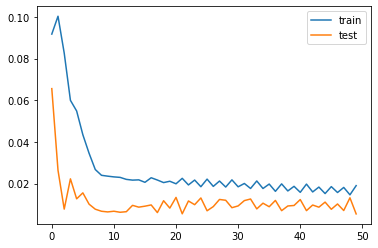

In [18]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)

2021-08-07 20:56:52.518378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-07 20:56:52.546331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [20]:
yhat.shape

(62, 1)

In [21]:
# Convert test data to 2D 
test_X = test_X.reshape((test_X.shape[0], weeks*n_features))

# invert scaling for forecast
# As we said Scaler needs 3 columns so we can take those columns from test data and take again the predictions
# Concatenate last 2 columns of test data with predicted data (yhat)
inv_yhat = concatenate((test_X[:, -(n_features-1):], yhat), axis=1)
# Inverse Scaler
inv_yhat = scaler.inverse_transform(inv_yhat)
# Take predicted data scaled to original Dengue cases
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
# Same process than for predicted data (yhat)
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -(n_features-1):], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [22]:
from sklearn.metrics import  mean_absolute_error

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 4.478


#### Plot predicted vs actual dengue cases

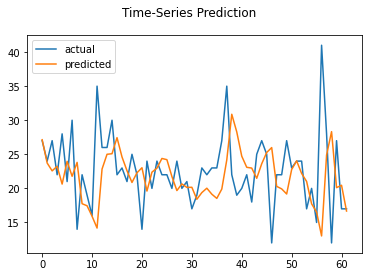

In [23]:
data_predict = inv_yhat  ## predicted target  cases
dataY_plot = inv_y  ##  real test-target cases

data_predict = data_predict.reshape(len(data_predict), 1)
dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)

import matplotlib.pyplot as plt

plt.plot(dataY_plot, label = 'actual')
plt.plot(data_predict, label = 'predicted')
plt.legend(loc="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

<ol>
  <li> <a href="https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915">Predictive Analytics: Time-Series Forecasting with GRU and BiLSTM in TensorFlow</a></li>
  <li><a href="https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/">Multivariate Time Series Forecasting with LSTMs in Keras</a></li>
</ol>